## 作业

- 用 Logistic Regression 分类以下数据集,计算训练 Accuracy 和 F1-score
- 用同样的方式生成验证集进行验证，计算验证 Accuracy 和 F1-score
- 确定最优特征数（最高幂次）
- （选做）用 L2 正则化，确定最优正则化系数

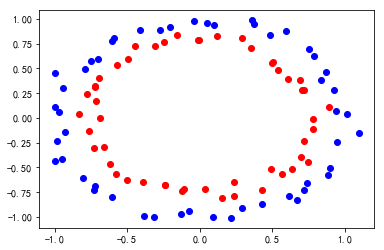

In [108]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.datasets.samples_generator import make_circles

XX,yy = make_circles(n_samples=100,noise= 0.05,)
m = XX.shape[0]
plt.plot(XX[np.where(yy == 1),0],XX[(np.where(yy == 1)),1],'ro');
plt.plot(XX[np.where(yy == 0),0],XX[(np.where(yy == 0)),1],'bo');

这个图实际包含三个变量，一种俯视图，蓝色0，红色为1，x1,x2各为一个变量

# 1 Logistic Regression 分类以下数据集

In [126]:
import pandas as pd  # 导入库
import numpy as np
from pylab import plot, xlabel, ylabel, legend, figure, contour
%matplotlib inline     
#上行具体作用：当调用matplotlib.pyplot的绘图函数plot()进行绘图的时候，或者生成一个figure画布的时候，可以直接在python console里面生成图像。
import matplotlib # 注意这个也要import一次,原因不是很清楚
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
# 使用Matplotlib的字体管理器加载中文字体
my_font=fm.FontProperties(fname="C:\Windows\Fonts\simsunb.ttf")
plt.rcParams['font.sans-serif']=['SimHei']

#解决负号'-'显示为方块的问题
matplotlib.rcParams['axes.unicode_minus'] = False


# 1.1 logistic regression 的 cost function与sigmoid函数

矩阵形式:$$ J = -\frac{1}{m}[Y^T\log(g(X\Theta))+(\mathbb{1}-Y)^T\log(\mathbb{1}-g(X\Theta))]$$
sigmoid函数：$$g(z)=\frac{1}{1+e^{-z}}$$

In [127]:
# logistic regression 的 cost function
def CostFunction(X,Theta,Y,m):
    z = np.dot(X,Theta)
    h = sigmod(z)
    H=np.log10(h)
    H1 =np.log10(1-h) 
    Y1=1-Y
    return -(np.dot(Y.T,H)+np.dot(Y1.T,H1))/m
# sigmod 函数
def sigmod(z):
    return 1/(1+np.exp(-z))

## 1.2 二维的Feature Mapping

|$1$|$x_1$|$x_2$|$x_3$|$x_4$|$x_5$|$x_6$|$x_7$|$x_8$|$x_9$|...|
|---|-----|-----|-----|-----|-----|-----|-----|-----|-----|---|
|$1$|$x_1$|$x_2$|$x_1^2$|$x_1 x_2$|$x_2^2$|$x_1^3$|$x_1^2 x_2$|$x_1 x_2^2$|$x_2^3$|...|

In [143]:
# n 表示最高阶幂函数的幂次
def FeatureMapping(x1,x2,n):     
    """
    定义幂函数特征项
    {x1,x2}--训练集的 x 值的两个分量
    n-- 表示最高阶幂次
    输出 (m,2n+1) 的 np.array
    """
    m = len(x1)
    f = 2*n+1 # 
    XX = np.ones((m,1))
   
    for i in np.arange(1,n+1):
        for j in np.arange(i+1):
            g=np.power(x1,i-j)*np.power(x2,j)
            XX = np.column_stack((XX,g))
    return XX

In [149]:
n = 8
x1 = XX[:,0]
x2 = XX[:,1]
X = FeatureMapping(x1,x2,n)

# 给定最高次幂 n , 计算特征数
k = 0
for i in np.arange(n+2):
    k = i+k
#（k特征数）    
# set the random initial values for Theta
Theta=np.random.rand(k).reshape(k,1) 
print("最高次幂：",n ,"\n", "特征数：",k)

最高次幂： 8 
 特征数： 45


关于[column_stack](https://blog.csdn.net/Jack_kun/article/details/82811229)

## 1.3 Training

$$\Theta:=\Theta-\frac{\alpha}{m}X^T(g(X\Theta)-Y)+\lambda\Theta_1$$
$$J = -\frac{1}{m}[Y^T\log(g(X\Theta))+(\mathbb{1}-Y)^T\log(\mathbb{1}-g(X\Theta))]+\frac{\lambda}{2m}\Theta_1^T\Theta_1$$

Final J value: 0.001126635378655313


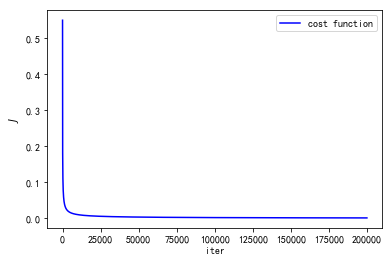

In [130]:
iter=200000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
lamda = 0; # 正则化系数
m = len(x1)
Y = yy.reshape(m,1)
# 准备储存每步迭代的 loss function 值
J_history=np.zeros((iter,1))

for i in np.arange(iter):
    z=np.dot(X,Theta)
    h=sigmod(z)
    Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
    Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
    Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
    J_history[i,0] = CostFunction(X,Theta,Y,m)+lamda/2/m*np.dot(Theta1.T,Theta1)       #后面为正则化
    
plt.plot(J_history[:,0],"b-",label="cost function");
plt.xlabel("iter")
plt.ylabel("$J$")
plt.legend(loc="best");
print("Final J value:",J_history[-1,0])

# 将训练的得到权重和预测的分类存储下来。
Theta_prediction = Theta
Y_prediction = sigmod(np.dot(FeatureMapping(x1,x2,n),Theta_prediction))

对特征做标准化处理，是为了使得正则化可以起作用。要确保所有特征的衡量标准统一

## 1.4 画出分类边界

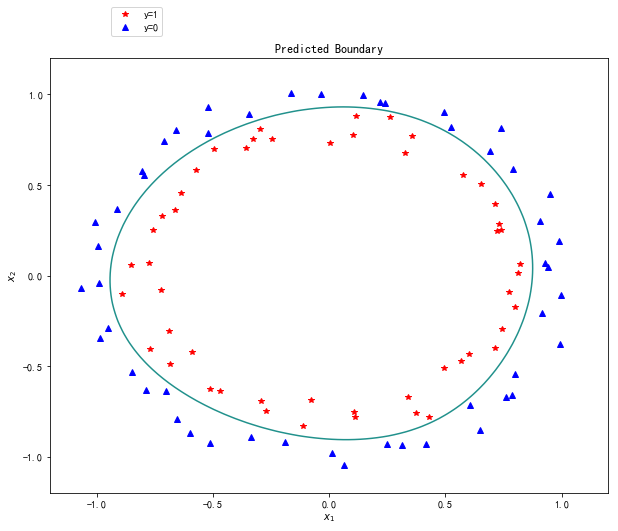

In [83]:
# 定义网格点的 Feature Mapping 函数
def FeatureMappingS(x1,x2,n):     
    """
    定义幂函数特征项
    x1,x2--训练集的 x 值的两个分量
    n-- 表示最高阶幂次
    输出：(1,2*n+1)的 np.array
    """
    XX = np.ones((1,1))       #产生二维1*1矩阵,数值为1
   
    for i in np.arange(1,n+1):
        for j in np.arange(i+1):
            g=np.power(x1,i-j)*np.power(x2,j)
            XX = np.column_stack((XX,g))
    return XX

u = np.linspace(-1.2,1.2,100)
v = np.linspace(-1.2,1.2,100)
z = np.zeros((100,100))
#画出每个点对应的z值
for i in np.arange(100):
    for j in np.arange(100):
        z[i,j]=np.dot(FeatureMappingS(u[i],v[j],n),Theta_prediction)          #X*theta，还没有作用于sigmoid


Z = z.T
figure(figsize=(10,8))

# 画分类边界 Z=0
contour(u,v,Z,0)           #等高线, 0是只画高度为0的线，因为sigmoid函数的分类边界为0，且Z本身是一个网格化了的结果
legend(labels=['Predicted Boundary'],loc='best')
# 画样本点
plot(x1[np.where(yy==1)],x2[np.where(yy==1)],"r*",label="y=1")
plot(x1[np.where(yy==0)],x2[np.where(yy==0)],"b^",label="y=0")



xlabel('$x_1$')
ylabel('$x_2$')
plt.axis([-1.2,1.2,-1.2,1.2]) # plt.axis([Xmin,Xmax,Ymin,Ymax])
legend(bbox_to_anchor=(0.21,1.13));
plt.title("Predicted Boundary");

这里产生了疑问为什么图例无法输出呢？

因为这是等高线，由多个颜色构成，事实上Z=0才是分界面，也因此只有一条线，看起来就像一个二维的函数一样，但是事实上本身是三维降维的一个结果。画出3D图就知道了

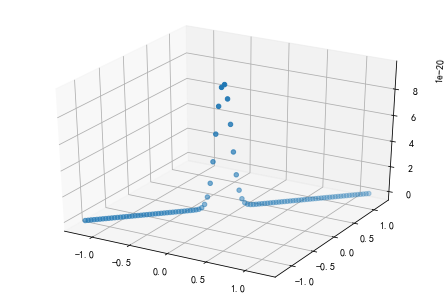

In [84]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure()
ax = Axes3D(fig)
Zz = sigmod(Z)
ax.scatter(u, v, Zz[:,1])
plt.show()

补充：那么学习的函数代入训练值得输出值到底是什么样的呢？

In [78]:
a=np.dot(X,Theta)
print(a)
b=sigmod(a)
print(b)
c = np.linspace(1,100,100)

[[-18.45927643]
 [ -5.90833492]
 [-13.29458101]
 [ 13.3138555 ]
 [  8.68468579]
 [ -9.54909484]
 [-18.97875777]
 [-32.10422644]
 [  5.22659283]
 [ -8.95125637]
 [  9.06939159]
 [-22.67607105]
 [ 13.21182822]
 [ -9.67972936]
 [ -9.0457018 ]
 [ 11.75726036]
 [ -9.22175388]
 [ 10.68942627]
 [  5.67301349]
 [ 11.44872599]
 [  7.00695281]
 [ 14.77246968]
 [-26.67412739]
 [-23.19547027]
 [-26.41032259]
 [  5.57036209]
 [ -6.2053396 ]
 [  9.27508365]
 [ -6.84791924]
 [ 14.29535699]
 [  8.98400283]
 [ 11.49667492]
 [  8.59797777]
 [ -4.57945676]
 [  3.92018477]
 [ -8.82646916]
 [ 10.07048533]
 [ -8.6358469 ]
 [  7.90758426]
 [-16.8981138 ]
 [  5.54755718]
 [-16.62505031]
 [ -5.50113033]
 [-27.06946139]
 [ 11.92327566]
 [  4.57948149]
 [ 12.96448908]
 [ 11.76454123]
 [  8.00933314]
 [  6.12968268]
 [-22.6938897 ]
 [ 12.28815169]
 [-17.60382075]
 [  6.48616511]
 [ -4.7165465 ]
 [ -5.8833274 ]
 [-12.07135445]
 [-10.86595406]
 [-11.97587031]
 [ -6.8415117 ]
 [ 11.22710017]
 [  8.92221194]
 [  5.96

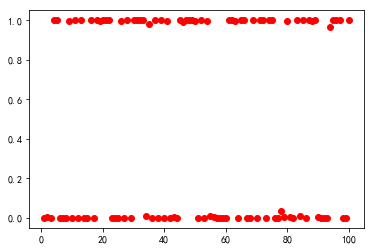

In [80]:
plot(c,b,"ro")

事实上对应的就是0和1，而sigmoid函数是一个除了中心范围，负无穷趋近0，正无穷趋近1得函数，所以可以通过调节x得输出值那变相调节结果输出0 or 1

## 2.1 Confusion Matrix 和 F1-score

Confusion Matrix:

$t_p$为真阳性，即数据为真，预测结果也为真。

$f_p$为假阳性，即数据为真，预测结果却为假。

$f_n$为假阴性，即数据为假，预测结果却为真。

$t_n$为真阴性，即数据为假，预测结果也为假。

各类指标: Accuracy()、Precision(正确率)、Recall(召回率)、F1-score()

In [137]:
Y_target=yy.reshape(100,1)
# Confusion Matrix
tp = len(np.where((Y_prediction >= 0.5) & (Y_target == 1))[0])
tn = len(np.where((Y_prediction < 0.5) & (Y_target == 0))[0])
fp = len(np.where((Y_prediction < 0.5) & (Y_target == 1))[0])
fn = len(np.where((Y_prediction >= 0.5) & (Y_target == 0))[0])

# 计算各类指标
Accuracy = (tp+tn)/(tp+tn+fp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
F1_score = 2/(1/Recall + 1/Precision)

print("n:",n)
print("Training Accuracy:",Accuracy )
print("Training Precision:",Precision )
print("Training Recall:",Recall )
print("Training F1-score:",F1_score)

n: 8
Training Accuracy: 1.0
Training Precision: 1.0
Training Recall: 1.0
Training F1-score: 1.0


计算结果是这样说明，fp,fn等于0，所以才使指标全为一，事实上这些指标都是越接近1，越好

## 2.2 Cross Valiadation

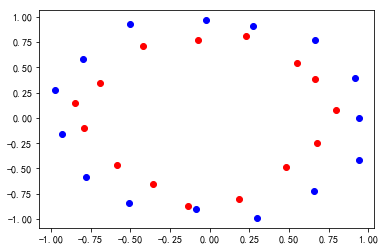

In [138]:
# 验证集样本数
m_cv = np.int(0.3*m)

# 生成验证集
X_cv,y_cv = make_circles(n_samples=30,noise= 0.05,)
m = X_cv.shape[0]
x1 = X_cv[:,0]
x2 = X_cv[:,1]

# 画验证集的样本点
plt.plot(X_cv[np.where(y_cv == 1),0],X_cv[(np.where(y_cv == 1)),1],'ro',label="y=1");
plt.plot(X_cv[np.where(y_cv == 0),0],X_cv[(np.where(y_cv == 0)),1],'bo',label="y=0");

Y_prediction = sigmod(np.dot(FeatureMapping(x1,x2,n),Theta_prediction))

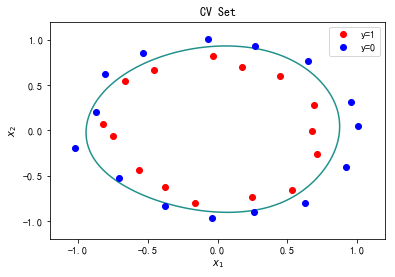

In [117]:
# 画预测的分类边界
contour(u,v,Z,0)

# 画验证集的样本点
plt.plot(x1[np.where(y_cv == 1)],x2[(np.where(y_cv == 1))],'ro',label="y=1");
plt.plot(x1[np.where(y_cv == 0)],x2[(np.where(y_cv == 0))],'bo',label="y=0");

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("CV Set")
#plt.legend(loc="center")
plt.legend()
plt.axis([-1.2,1.2,-1.2,1.2]); # plt.axis([Xmin,Xmax,Ymin,Ymax])

## 2.2.1 Confusion Matrix 和 F1-score

In [139]:
Y_cv=y_cv.reshape(30,1)
# Confusion Matrix
tp = len(np.where((Y_prediction >= 0.5) & (Y_cv == 1))[0])
tn = len(np.where((Y_prediction < 0.5) & (Y_cv == 0))[0])
fp = len(np.where((Y_prediction < 0.5) & (Y_cv == 1))[0])
fn = len(np.where((Y_prediction >= 0.5) & (Y_cv == 0))[0])

# 计算各类指标
Accuracy = (tp+tn)/(tp+tn+fp+fn)
Precision = tp/(tp+fp)
Recall = tp/(tp+fn)
F1_score = 2/(1/Recall + 1/Precision)

print("n:",n)
print("Training Accuracy:",Accuracy )
print("Training Precision:",Precision )
print("Training Recall:",Recall )
print("Training F1-score:",F1_score)

n: 8
Training Accuracy: 0.9666666666666667
Training Precision: 0.9333333333333333
Training Recall: 1.0
Training F1-score: 0.9655172413793105


## 2.3 确定最优特征数

最高次幂： 1 
 特征数： 3
最高次幂： 2 
 特征数： 6
最高次幂： 3 
 特征数： 10
最高次幂： 4 
 特征数： 15
最高次幂： 5 
 特征数： 21
最高次幂： 6 
 特征数： 28
最高次幂： 7 
 特征数： 36
最高次幂： 8 
 特征数： 45
最高次幂： 9 
 特征数： 55
最高次幂： 10 
 特征数： 66
最高次幂： 11 
 特征数： 78
最高次幂： 12 
 特征数： 91
最高次幂： 13 
 特征数： 105
最高次幂： 14 
 特征数： 120


Text(0, 0.5, '误差值')

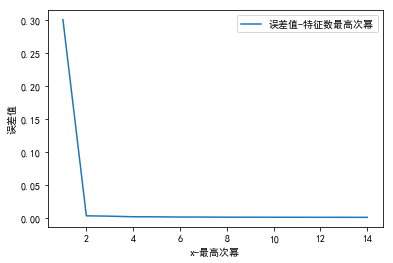

In [165]:
#训练集
# 固定训练集
np.random.seed(3)      #(每次计算会有相同的样本，前提是编号1相对应)

n = []
for k in range(14):
    n.append(k+1)
Error = []
j = 0
x1 = XX[:,0]
x2 = XX[:,1]
iter=200000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
lamda = 0; # 正则化系数
m = len(x1)
Y = yy.reshape(m,1)

for i in range(14):
    X = FeatureMapping(x1,x2,n[j])
    # 给定最高次幂 n , 计算特征数
    u = 0
    for w in np.arange(n[j]+2):
        u = w+u
    #（u特征数）    
    # set the random initial values for Theta
    Theta=np.random.rand(u).reshape(u,1) 
    print("最高次幂：",n[j] ,"\n", "特征数：",u)
    # 准备储存每步迭代的 loss function 值
    J_history=np.zeros((iter,1))

    for s in np.arange(iter):
        z=np.dot(X,Theta)
        h=sigmod(z)
        Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
        Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
        Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
        J_history[s,0] = CostFunction(X,Theta,Y,m)+lamda/2/m*np.dot(Theta1.T,Theta1)       #后面为正则化
    Error.append(J_history[-1,0])
    j+= 1
fig5, = plot(n,Error);             #加逗号是为了输出图例
legend(handles=[fig5], labels=['误差值-特征数最高次幂'])           #输出图例
xlabel("x-最高次幂")
ylabel("误差值")

由于1的误差值实在太大，看不出其他的最高次幂哪个在固定迭代次数后是最好的

最高次幂： 2 
 特征数： 6
最高次幂： 3 
 特征数： 10
最高次幂： 4 
 特征数： 15
最高次幂： 5 
 特征数： 21
最高次幂： 6 
 特征数： 28
最高次幂： 7 
 特征数： 36
最高次幂： 8 
 特征数： 45
最高次幂： 9 
 特征数： 55
最高次幂： 10 
 特征数： 66
最高次幂： 11 
 特征数： 78
最高次幂： 12 
 特征数： 91
最高次幂： 13 
 特征数： 105
最高次幂： 14 
 特征数： 120
最高次幂： 15 
 特征数： 136
最高次幂： 16 
 特征数： 153
最高次幂： 17 
 特征数： 171
最高次幂： 18 
 特征数： 190
最高次幂： 19 
 特征数： 210
最高次幂： 20 
 特征数： 231
最高次幂： 21 
 特征数： 253
最高次幂： 22 
 特征数： 276
最高次幂： 23 
 特征数： 300
最高次幂： 24 
 特征数： 325


D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


最高次幂： 25 
 特征数： 351
最高次幂： 26 
 特征数： 378
最高次幂： 27 
 特征数： 406
最高次幂： 28 
 特征数： 435
最高次幂： 29 
 特征数： 465
最高次幂： 30 
 特征数： 496
最高次幂： 31 
 特征数： 528
最高次幂： 32 
 特征数： 561
最高次幂： 33 
 特征数： 595
最高次幂： 34 
 特征数： 630
最高次幂： 35 
 特征数： 666
最高次幂： 36 
 特征数： 703
最高次幂： 37 
 特征数： 741
最高次幂： 38 
 特征数： 780
最高次幂： 39 
 特征数： 820
最高次幂： 40 
 特征数： 861
最高次幂： 41 
 特征数： 903
最高次幂： 42 
 特征数： 946
最高次幂： 43 
 特征数： 990


D:\software\anaconda\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log10
  """


最高次幂： 44 
 特征数： 1035
最高次幂： 45 
 特征数： 1081
最高次幂： 46 
 特征数： 1128
最高次幂： 47 
 特征数： 1176
最高次幂： 48 
 特征数： 1225
最高次幂： 49 
 特征数： 1275
最高次幂： 50 
 特征数： 1326
最高次幂： 51 
 特征数： 1378


Text(0, 0.5, '误差值')

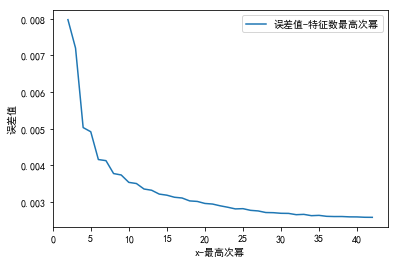

In [170]:
#训练集
# 固定训练集
np.random.seed(3)      #(每次计算会有相同的样本，前提是编号1相对应)

n = []
for k in range(50):
    n.append(k+2)
Error = []
j = 0
x1 = XX[:,0]
x2 = XX[:,1]
iter=20000;    # 梯度下降迭代次数
alpha=1.1;        # 学习步长
lamda = 0; # 正则化系数
m = len(x1)
Y = yy.reshape(m,1)

for i in range(50):
    X = FeatureMapping(x1,x2,n[j])
    # 给定最高次幂 n , 计算特征数
    u = 0
    for w in np.arange(n[j]+2):
        u = w+u
    #（u特征数）    
    # set the random initial values for Theta
    Theta=np.random.rand(u).reshape(u,1) 
    print("最高次幂：",n[j] ,"\n", "特征数：",u)
    # 准备储存每步迭代的 loss function 值
    J_history=np.zeros((iter,1))

    for s in np.arange(iter):
        z=np.dot(X,Theta)
        h=sigmod(z)
        Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
        Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
        Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
        J_history[s,0] = CostFunction(X,Theta,Y,m)+lamda/2/m*np.dot(Theta1.T,Theta1)       #后面为正则化
    Error.append(J_history[-1,0])
    j+= 1
fig5, = plot(n,Error);             #加逗号是为了输出图例
legend(handles=[fig5], labels=['误差值-特征数最高次幂'])           #输出图例
xlabel("x-最高次幂")
ylabel("误差值")

理论上n，越大，误差值越小，理论与计算拟合的非常好，但这也导致没法寻找最优N,所以还要结合交叉验证，防止过学习

最高次幂： 2 
 特征数： 6
最高次幂： 3 
 特征数： 10
最高次幂： 4 
 特征数： 15
最高次幂： 5 
 特征数： 21
最高次幂： 6 
 特征数： 28
最高次幂： 7 
 特征数： 36
最高次幂： 8 
 特征数： 45
最高次幂： 9 
 特征数： 55
最高次幂： 10 
 特征数： 66
最高次幂： 11 
 特征数： 78
最高次幂： 12 
 特征数： 91
最高次幂： 13 
 特征数： 105
最高次幂： 14 
 特征数： 120
最高次幂： 15 
 特征数： 136
最高次幂： 16 
 特征数： 153
最高次幂： 17 
 特征数： 171
最高次幂： 18 
 特征数： 190
最高次幂： 19 
 特征数： 210
最高次幂： 20 
 特征数： 231
最高次幂： 21 
 特征数： 253
最高次幂： 22 
 特征数： 276
最高次幂： 23 
 特征数： 300
最高次幂： 24 
 特征数： 325
最高次幂： 25 
 特征数： 351
最高次幂： 26 
 特征数： 378
最高次幂： 27 
 特征数： 406
最高次幂： 28 
 特征数： 435
最高次幂： 29 
 特征数： 465
最高次幂： 30 
 特征数： 496
最高次幂： 31 
 特征数： 528
最高次幂： 32 
 特征数： 561
最高次幂： 33 
 特征数： 595
最高次幂： 34 
 特征数： 630
最高次幂： 35 
 特征数： 666
最高次幂： 36 
 特征数： 703
最高次幂： 37 
 特征数： 741
最高次幂： 38 
 特征数： 780
最高次幂： 39 
 特征数： 820
最高次幂： 40 
 特征数： 861
最高次幂： 41 
 特征数： 903
最高次幂： 42 
 特征数： 946
最高次幂： 43 
 特征数： 990
最高次幂： 44 
 特征数： 1035
最高次幂： 45 
 特征数： 1081
最高次幂： 46 
 特征数： 1128
最高次幂： 47 
 特征数： 1176
最高次幂： 48 
 特征数： 1225
最高次幂： 49 
 特征数： 1275
最高次幂： 50 
 特征数： 1326
最高次幂： 51 
 特征数： 1378


Text(0, 0.5, '误差值')

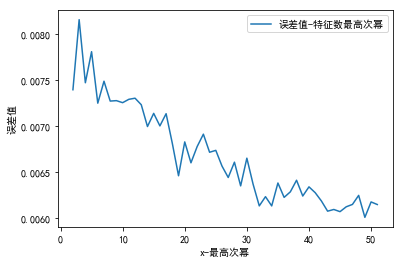

In [175]:
#交叉集
# 固定训练集
np.random.seed(5)      #(每次计算会有相同的样本，前提是编号1相对应)

n = []
for k in range(50):
    n.append(k+2)
Error = []
j = 0
iter=20000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
lamda = 0; # 正则化系数
x1 = XX[:,0]
m = len(x1)
Y = yy.reshape(m,1)

for i in range(50):
    x1 = XX[:,0]
    x2 = XX[:,1]
    X = FeatureMapping(x1,x2,n[j])
    # 输出最高次幂 n , 计算特征数
    u = 0
    for w in np.arange(n[j]+2):
        u = w+u
    #（u特征数）    
    # set the random initial values for Theta
    np.random.seed(6)
    Theta=np.random.rand(u).reshape(u,1) 
    print("最高次幂：",n[j] ,"\n", "特征数：",u)
    # 准备储存每步迭代的 loss function 值
    J_history=np.zeros((iter,1))

    for s in np.arange(iter):
        z=np.dot(X,Theta)
        h=sigmod(z)
        Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
        Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
        Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
    x1 = X_cv[:,0]
    x2 = X_cv[:,1]
    X = FeatureMapping(x1,x2,n[j])
    J_history[s,0] = CostFunction(X,Theta,Y_cv,m)+lamda/2/m*np.dot(Theta1.T,Theta1)
    E = J_history[-1,0]
    Error.append(E.item())

    
    j+= 1
fig5, = plot(n,Error);             #加逗号是为了输出图例
legend(handles=[fig5], labels=['误差值-特征数最高次幂'])           #输出图例
xlabel("x-最高次幂")
ylabel("误差值")

最高次幂： 19 
 特征数： 210
最高次幂： 20 
 特征数： 231
最高次幂： 21 
 特征数： 253
最高次幂： 22 
 特征数： 276
最高次幂： 23 
 特征数： 300
最高次幂： 24 
 特征数： 325
最高次幂： 25 
 特征数： 351
最高次幂： 26 
 特征数： 378
最高次幂： 27 
 特征数： 406
最高次幂： 28 
 特征数： 435
最高次幂： 29 
 特征数： 465
最高次幂： 30 
 特征数： 496
最高次幂： 31 
 特征数： 528
最高次幂： 32 
 特征数： 561
最高次幂： 33 
 特征数： 595
最高次幂： 34 
 特征数： 630
最高次幂： 35 
 特征数： 666
最高次幂： 36 
 特征数： 703
最高次幂： 37 
 特征数： 741
最高次幂： 38 
 特征数： 780
最高次幂： 39 
 特征数： 820
最高次幂： 40 
 特征数： 861
最高次幂： 41 
 特征数： 903
最高次幂： 42 
 特征数： 946
最高次幂： 43 
 特征数： 990
最高次幂： 44 
 特征数： 1035
最高次幂： 45 
 特征数： 1081
最高次幂： 46 
 特征数： 1128
最高次幂： 47 
 特征数： 1176
最高次幂： 48 
 特征数： 1225
最高次幂： 49 
 特征数： 1275
最高次幂： 50 
 特征数： 1326
最高次幂： 51 
 特征数： 1378
最高次幂： 52 
 特征数： 1431
最高次幂： 53 
 特征数： 1485


Text(0, 0.5, '误差值')

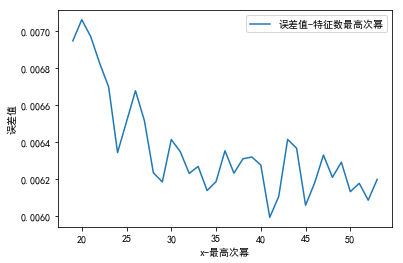

In [184]:
#交叉集
# 固定训练集
np.random.seed(5)      #(每次计算会有相同的样本，前提是编号1相对应)

n = []
for k in range(35):
    n.append(k+19)
Error = []
j = 0
iter=20000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
lamda = 0; # 正则化系数
x1 = XX[:,0]
m = len(x1)
Y = yy.reshape(m,1)

for i in range(35):
    x1 = XX[:,0]
    x2 = XX[:,1]
    X = FeatureMapping(x1,x2,n[j])
    # 输出最高次幂 n , 计算特征数
    u = 0
    for w in np.arange(n[j]+2):
        u = w+u
    #（u特征数）    
    # set the random initial values for Theta
    Theta=np.random.rand(u).reshape(u,1) 
    print("最高次幂：",n[j] ,"\n", "特征数：",u)
    # 准备储存每步迭代的 loss function 值
    J_history=np.zeros((iter,1))

    for s in np.arange(iter):
        z=np.dot(X,Theta)
        h=sigmod(z)
        Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
        Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
        Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
    x1 = X_cv[:,0]
    x2 = X_cv[:,1]
    X = FeatureMapping(x1,x2,n[j])
    J_history[s,0] = CostFunction(X,Theta,Y_cv,m)+lamda/2/m*np.dot(Theta1.T,Theta1)
    E = J_history[-1,0]
    Error.append(E.item())

    
    j+= 1
fig5, = plot(n,Error);             #加逗号是为了输出图例
legend(handles=[fig5], labels=['误差值-特征数最高次幂'])           #输出图例
xlabel("x-最高次幂")
ylabel("误差值")

最高次幂： 39 
 特征数： 820
最高次幂： 40 
 特征数： 861
最高次幂： 41 
 特征数： 903
最高次幂： 42 
 特征数： 946
最高次幂： 43 
 特征数： 990
最高次幂： 44 
 特征数： 1035
最高次幂： 45 
 特征数： 1081
最高次幂： 46 
 特征数： 1128
最高次幂： 47 
 特征数： 1176
最高次幂： 48 
 特征数： 1225
最高次幂： 49 
 特征数： 1275
最高次幂： 50 
 特征数： 1326
最高次幂： 51 
 特征数： 1378
最高次幂： 52 
 特征数： 1431
最高次幂： 53 
 特征数： 1485


Text(0, 0.5, '误差值')

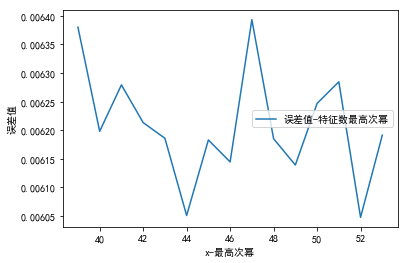

In [185]:
#交叉集
# 固定训练集
np.random.seed(5)      #(每次计算会有相同的样本，前提是编号1相对应)

n = []
for k in range(15):
    n.append(k+39)
Error = []
j = 0
iter=20000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
lamda = 0; # 正则化系数
x1 = XX[:,0]
m = len(x1)
Y = yy.reshape(m,1)

for i in range(15):
    x1 = XX[:,0]
    x2 = XX[:,1]
    X = FeatureMapping(x1,x2,n[j])
    # 输出最高次幂 n , 计算特征数
    u = 0
    for w in np.arange(n[j]+2):
        u = w+u
    #（u特征数）    
    # set the random initial values for Theta
    Theta=np.random.rand(u).reshape(u,1) 
    print("最高次幂：",n[j] ,"\n", "特征数：",u)
    # 准备储存每步迭代的 loss function 值
    J_history=np.zeros((iter,1))

    for s in np.arange(iter):
        z=np.dot(X,Theta)
        h=sigmod(z)
        Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
        Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
        Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
    x1 = X_cv[:,0]
    x2 = X_cv[:,1]
    X = FeatureMapping(x1,x2,n[j])
    J_history[s,0] = CostFunction(X,Theta,Y_cv,m)+lamda/2/m*np.dot(Theta1.T,Theta1)
    E = J_history[-1,0]
    Error.append(E.item())

    
    j+= 1
fig5, = plot(n,Error);             #加逗号是为了输出图例
legend(handles=[fig5], labels=['误差值-特征数最高次幂'])           #输出图例
xlabel("x-最高次幂")
ylabel("误差值")

综合来看，在不使用L2正则化的时候，n = 44的时候普适性较好，但其实这样判断有些问题，因为每次产生的随机数会有不同，所以带来的结果就是最佳次幂在n=42-52之前波动

# 3 L2正则化

由于之前已经确定了最佳次幂n = 44，接下来调节正则化系数实现交叉解的普适性，学习效果最好

最高次幂： 44 
 特征数： 1035


Text(0, 0.5, '误差值')

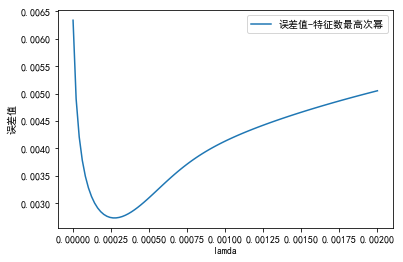

In [192]:
#交叉集
# 固定训练集
np.random.seed(5)      #(每次计算会有相同的样本，前提是编号1相对应)

lamda = np.linspace(0,0.002,100) # 正则化系数
n = 44
Error = []
j = 0
iter=20000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
x1 = XX[:,0]
m = len(x1)
Y = yy.reshape(m,1)
# 输出最高次幂 n , 计算特征数
u = 0
for w in np.arange(n+2):
    u = w+u
#（u特征数）    
# set the random initial values for Theta
Theta=np.random.rand(u).reshape(u,1) 
print("最高次幂：",n ,"\n", "特征数：",u)
# 准备储存每步迭代的 loss function 值
for i in range(100):
    x1 = XX[:,0]
    x2 = XX[:,1]
    X = FeatureMapping(x1,x2,n)
    J_history=np.zeros((iter,1))

    for s in np.arange(iter):
        z=np.dot(X,Theta)
        h=sigmod(z)
        Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
        Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
        Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda[j]*Theta1)                         #对耗散函数求导的结果
    x1 = X_cv[:,0]
    x2 = X_cv[:,1]
    X = FeatureMapping(x1,x2,n)
    J_history[s,0] = CostFunction(X,Theta,Y_cv,m)
    E = J_history[-1,0]
    Error.append(E.item())

    
    j+= 1
fig5, = plot(lamda,Error);             #加逗号是为了输出图例
legend(handles=[fig5], labels=['误差值-特征数最高次幂'])           #输出图例
xlabel("lamda")
ylabel("误差值")

根据图像，正则化系数在0.0025左右可以得到最佳的学习系数，得到最优化系数

最高次幂： 44 
 特征数： 1035


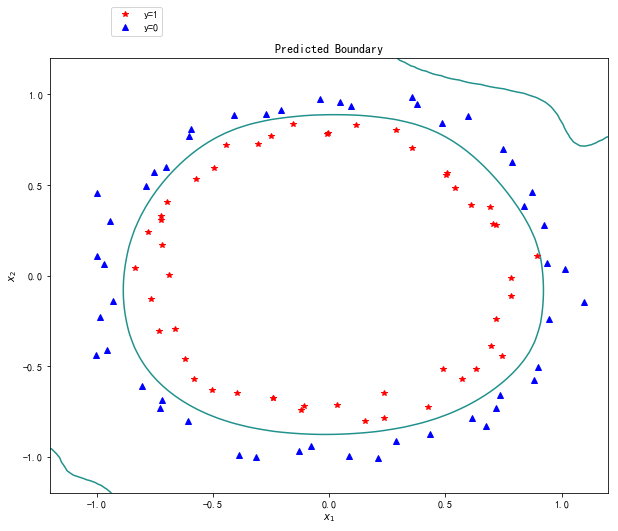

In [194]:
n = 44
x1 = XX[:,0]
x2 = XX[:,1]
X = FeatureMapping(x1,x2,n)

# 给定最高次幂 n , 计算特征数
k = 0
for i in np.arange(n+2):
    k = i+k
#（k特征数）    
# set the random initial values for Theta
Theta=np.random.rand(k).reshape(k,1) 
print("最高次幂：",n ,"\n", "特征数：",k)
iter=20000;    # 梯度下降迭代次数
alpha=0.5;        # 学习步长
lamda = 0.00025; # 正则化系数
m = len(x1)
Y = yy.reshape(m,1)
# 准备储存每步迭代的 loss function 值
J_history=np.zeros((iter,1))

for i in np.arange(iter):
    z=np.dot(X,Theta)
    h=sigmod(z)
    Theta1 = np.copy(Theta) # 用于计算正则化项的权重，注意要去掉第一个权重
    Theta1[0,0]= 0 # 去掉第一个权重,因为给了2个1的系数，但事实上只需要一个就好了
    Theta = Theta -alpha/m*(np.dot(X.T,h-Y)+lamda*Theta1)                         #对耗散函数求导的结果
    

# 将训练的得到权重和预测的分类存储下来。
Theta_prediction = Theta
Y_prediction = sigmod(np.dot(FeatureMapping(x1,x2,n),Theta_prediction))

# 定义网格点的 Feature Mapping 函数
def FeatureMappingS(x1,x2,n):     
    """
    定义幂函数特征项
    x1,x2--训练集的 x 值的两个分量
    n-- 表示最高阶幂次
    输出：(1,2*n+1)的 np.array
    """
    XX = np.ones((1,1))       #产生二维1*1矩阵,数值为1
   
    for i in np.arange(1,n+1):
        for j in np.arange(i+1):
            g=np.power(x1,i-j)*np.power(x2,j)
            XX = np.column_stack((XX,g))
    return XX

u = np.linspace(-1.2,1.2,100)
v = np.linspace(-1.2,1.2,100)
z = np.zeros((100,100))
#画出每个点对应的z值
for i in np.arange(100):
    for j in np.arange(100):
        z[i,j]=np.dot(FeatureMappingS(u[i],v[j],n),Theta_prediction)          #X*theta，还没有作用于sigmoid


Z = z.T
figure(figsize=(10,8))

# 画分类边界 Z=0
contour(u,v,Z,0)           #等高线, 0是只画高度为0的线，因为sigmoid函数的分类边界为0，且Z本身是一个网格化了的结果
legend(labels=['Predicted Boundary'],loc='best')
# 画样本点
plot(x1[np.where(yy==1)],x2[np.where(yy==1)],"r*",label="y=1")
plot(x1[np.where(yy==0)],x2[np.where(yy==0)],"b^",label="y=0")



xlabel('$x_1$')
ylabel('$x_2$')
plt.axis([-1.2,1.2,-1.2,1.2]) # plt.axis([Xmin,Xmax,Ymin,Ymax])
legend(bbox_to_anchor=(0.21,1.13));
plt.title("Predicted Boundary");

Z = 0 的分界线不仅仅是一个圆，是一个拟合的结果，也没法去掉

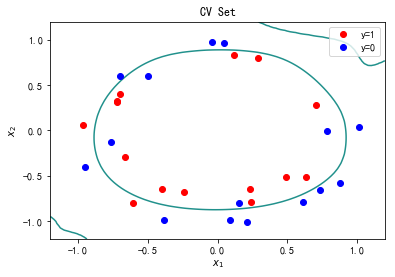

In [195]:
# 画预测的分类边界
contour(u,v,Z,0)

# 画验证集的样本点
plt.plot(x1[np.where(y_cv == 1)],x2[(np.where(y_cv == 1))],'ro',label="y=1");
plt.plot(x1[np.where(y_cv == 0)],x2[(np.where(y_cv == 0))],'bo',label="y=0");

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.title("CV Set")
#plt.legend(loc="center")
plt.legend()
plt.axis([-1.2,1.2,-1.2,1.2]); # plt.axis([Xmin,Xmax,Ymin,Ymax])